# Pass networks from Whoscored

Read the blogpost: https://www.dzialowski.eu/football-data-visualisations/

## Getting the match data from Whoscored

In [40]:
import json
import re
import pandas as pd

In [41]:
def extract_json_from_html(html_path, save_output=False):
    html_file = open(html_path, 'r')
    html = html_file.read()
    html_file.close()
    regex_pattern = r'(?<=require\.config\.params\["args"\].=.)[\s\S]*?;'
    data_txt = re.findall(regex_pattern, html)[0]

    # add quotations for json parser
    data_txt = data_txt.replace('matchId', '"matchId"')
    data_txt = data_txt.replace('matchCentreData', '"matchCentreData"')
    data_txt = data_txt.replace('matchCentreEventTypeJson', '"matchCentreEventTypeJson"')
    data_txt = data_txt.replace('formationIdNameMappings', '"formationIdNameMappings"')
    data_txt = data_txt.replace('};', '}')

    if save_output:
        # save json data to txt
        output_file = open(f"{html_path}.txt", "wt")
        n = output_file.write(data_txt)
        output_file.close()

    return data_txt

In [42]:
def extract_data_from_dict(data):
    # load data from json
    event_types_json = data["matchCentreEventTypeJson"]
    formation_mappings = data["formationIdNameMappings"]
    events_dict = data["matchCentreData"]["events"]
    teams_dict = {data["matchCentreData"]['home']['teamId']: data["matchCentreData"]['home']['name'],
                  data["matchCentreData"]['away']['teamId']: data["matchCentreData"]['away']['name']}
    players_dict = data["matchCentreData"]["playerIdNameDictionary"]
    # create players dataframe
    players_home_df = pd.DataFrame(data["matchCentreData"]['home']['players'])
    players_home_df["teamId"] = data["matchCentreData"]['home']['teamId']
    players_away_df = pd.DataFrame(data["matchCentreData"]['away']['players'])
    players_away_df["teamId"] = data["matchCentreData"]['away']['teamId']
    players_df = pd.concat([players_home_df, players_away_df])
    players_ids = data["matchCentreData"]["playerIdNameDictionary"]
    return events_dict, players_df, teams_dict

In [45]:
match_html_path = 'games/Leeds 2-1 Preston - Championship 2023_2024 Live.html'
json_data_txt = extract_json_from_html(match_html_path)
data = json.loads(json_data_txt)
events_dict, players_df, teams_dict = extract_data_from_dict(data)

## Preparing the data

In [24]:
players_df.head()

,playerId,shirtNo,name,position,height,weight,age,isFirstEleven,isManOfTheMatch,field,stats,subbedInPlayerId,subbedOutPeriod,subbedOutExpandedMinute,subbedInPeriod,subbedInExpandedMinute,subbedOutPlayerId,teamId
0,380580,1,Illan Meslier,GK,197,74,23,True,False,home,"{'totalSaves': {'10': 1.0}, 'parriedSafe': {'1...",NaN,NaN,NaN,NaN,NaN,NaN,19
1,429922,22,Archie Gray,DR,0,0,17,True,False,home,"{'possession': {'4': 1.0, '5': 1.0, '17': 2.0,...",NaN,NaN,NaN,NaN,NaN,NaN,19
2,322418,4,Ethan Ampadu,DC,182,78,23,True,False,home,"{'possession': {'2': 4.0, '5': 3.0, '7': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,19
3,302312,14,Joe Rodon,DC,193,88,26,True,False,home,"{'possession': {'0': 2.0, '2': 2.0, '4': 1.0, ...",NaN,NaN,NaN,NaN,NaN,NaN,19
4,351252,3,Junior Firpo,DL,184,78,27,True,False,home,"{'possession': {'2': 1.0, '5': 3.0, '7': 2.0, ...",118303.0,"{'value': 2, 'displayName': 'SecondHalf'}",78.0,NaN,NaN,NaN,19


### Passes dataframe

In [25]:
def get_passes_df(events_dict):
    df = pd.DataFrame(events_dict)
    df['eventType'] = df.apply(lambda row: row['type']['displayName'], axis=1)
    df['outcomeType'] = df.apply(lambda row: row['outcomeType']['displayName'], axis=1)

    # create receiver column based on the next event
    # this will be correct only for successfull passes
    df["receiver"] = df["playerId"].shift(-1)

    # filter only passes
    passes_ids = df.index[df['eventType'] == 'Pass']
    df_passes = df.loc[
        passes_ids, ["id", "x", "y", "endX", "endY", "teamId", "playerId", "receiver", "eventType", "outcomeType"]]

    return df_passes

In [26]:
passes_df = get_passes_df(events_dict)
passes_df.head()

,id,x,y,endX,endY,teamId,playerId,receiver,eventType,outcomeType
2,2.637788e+09,50.0,50.0,39.7,50.6,181,491382.0,253929.0,Pass,Successful
3,2.637788e+09,39.7,50.6,75.4,86.5,181,253929.0,302312.0,Pass,Unsuccessful
6,2.637788e+09,23.8,17.1,30.0,10.1,19,302312.0,391821.0,Pass,Unsuccessful
7,2.637788e+09,70.7,94.1,60.9,95.0,181,391821.0,134540.0,Pass,Unsuccessful
8,2.637788e+09,60.9,95.0,79.5,90.9,181,134540.0,302312.0,Pass,Unsuccessful


In [27]:
def get_passes_between_df(team_id, passes_df, players_df):
    # filter for only team
    passes_df = passes_df[passes_df["teamId"] == team_id]

    # add column with first eleven players only
    passes_df = passes_df.merge(players_df[["playerId", "isFirstEleven"]], on='playerId', how='left')
    # filter on first eleven column
    passes_df = passes_df[passes_df['isFirstEleven'] == True]

    # calculate mean positions for players
    average_locs_and_count_df = (passes_df.groupby('playerId')
                                 .agg({'x': ['mean'], 'y': ['mean', 'count']}))
    average_locs_and_count_df.columns = ['x', 'y', 'count']
    average_locs_and_count_df = average_locs_and_count_df.merge(players_df[['playerId', 'name', 'shirtNo', 'position']],
                                                                on='playerId', how='left')
    average_locs_and_count_df = average_locs_and_count_df.set_index('playerId')

    # calculate the number of passes between each position (using min/ max so we get passes both ways)
    passes_player_ids_df = passes_df.loc[:, ['id', 'playerId', 'receiver', 'teamId']]
    passes_player_ids_df['pos_max'] = (passes_player_ids_df[['playerId', 'receiver']].max(axis='columns'))
    passes_player_ids_df['pos_min'] = (passes_player_ids_df[['playerId', 'receiver']].min(axis='columns'))

    # get passes between each player
    passes_between_df = passes_player_ids_df.groupby(['pos_min', 'pos_max']).id.count().reset_index()
    passes_between_df.rename({'id': 'pass_count'}, axis='columns', inplace=True)

    # add on the location of each player so we have the start and end positions of the lines
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_min', right_index=True)
    passes_between_df = passes_between_df.merge(average_locs_and_count_df, left_on='pos_max', right_index=True,
                                                suffixes=['', '_end'])
    return passes_between_df, average_locs_and_count_df

In [28]:
home_team_id = list(teams_dict.keys())[0]  # selected home team
home_passes_between_df, home_average_locs_and_count_df = get_passes_between_df(home_team_id, passes_df, players_df)

In [29]:
away_team_id = list(teams_dict.keys())[1]  # selected home team
away_passes_between_df, away_average_locs_and_count_df = get_passes_between_df(away_team_id, passes_df, players_df)

## Visualisation

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import to_rgba
from mplsoccer import Pitch, FontManager

In [31]:
def pass_network_visualization(ax, passes_between_df, average_locs_and_count_df, flipped=False):
    MAX_LINE_WIDTH = 10
    MAX_MARKER_SIZE = 3000
    passes_between_df['width'] = (passes_between_df.pass_count / passes_between_df.pass_count.max() *
                                  MAX_LINE_WIDTH)
    average_locs_and_count_df['marker_size'] = (average_locs_and_count_df['count']
                                                / average_locs_and_count_df['count'].max() * MAX_MARKER_SIZE)

    MIN_TRANSPARENCY = 0.3
    color = np.array(to_rgba('#507293'))
    color = np.tile(color, (len(passes_between_df), 1))
    c_transparency = passes_between_df.pass_count / passes_between_df.pass_count.max()
    c_transparency = (c_transparency * (1 - MIN_TRANSPARENCY)) + MIN_TRANSPARENCY
    color[:, 3] = c_transparency

    pitch = Pitch(pitch_type='opta', pitch_color='#0D182E', line_color='#5B6378')
    pitch.draw(ax=ax)

    if flipped:
        passes_between_df['x'] = pitch.dim.right - passes_between_df['x']
        passes_between_df['y'] = pitch.dim.right - passes_between_df['y']
        passes_between_df['x_end'] = pitch.dim.right - passes_between_df['x_end']
        passes_between_df['y_end'] = pitch.dim.right - passes_between_df['y_end']
        average_locs_and_count_df['x'] = pitch.dim.right - average_locs_and_count_df['x']
        average_locs_and_count_df['y'] = pitch.dim.right - average_locs_and_count_df['y']

    pass_lines = pitch.lines(passes_between_df.x, passes_between_df.y,
                             passes_between_df.x_end, passes_between_df.y_end, lw=passes_between_df.width,
                             color=color, zorder=1, ax=ax)
    pass_nodes = pitch.scatter(average_locs_and_count_df.x, average_locs_and_count_df.y,
                               s=average_locs_and_count_df.marker_size, marker='h',
                               color='#004080', edgecolors='#000000', linewidth=1, alpha=1, ax=ax)
    for index, row in average_locs_and_count_df.iterrows():
        player_name = row["name"].split()
        player_initials = "".join(player_name[0][0] + ". " + player_name[1]) #"".join(word[0] for word in player_name).upper()
        pitch.annotate(player_initials, xy=(row.x, row.y), c='#FFFFFF', va='center',
                       ha='center', size=7, ax=ax)

    return pitch

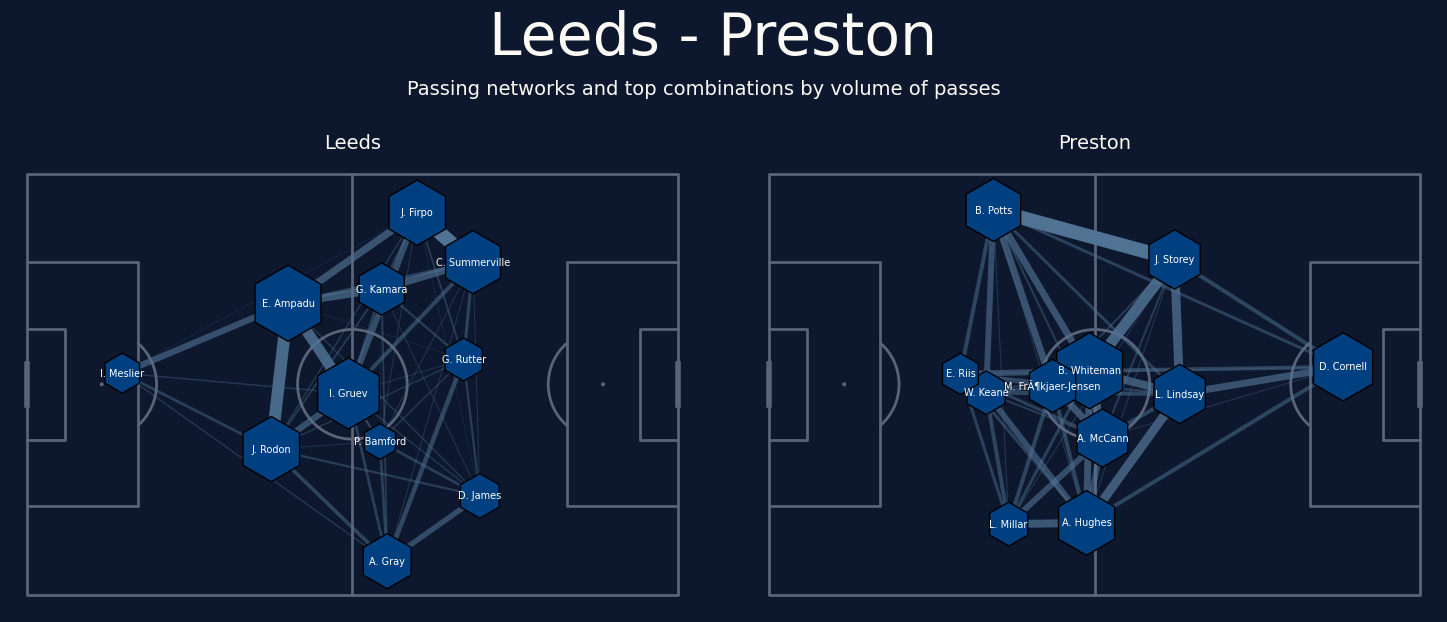

In [32]:
# create plot
fig, axes = plt.subplots(1, 2, figsize=(15, 8))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)
axes = axes.flat
plt.tight_layout()
fig.set_facecolor("#0D182E")

# plot variables
main_color = '#FBFAF5'
#font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/static/"
                         #"RobotoCondensed-Medium.ttf?raw=true"))

# home team viz
pass_network_visualization(axes[0], home_passes_between_df, home_average_locs_and_count_df)
axes[0].set_title(teams_dict[home_team_id], color=main_color, fontsize=14)

# away team viz
pass_network_visualization(axes[1], away_passes_between_df, away_average_locs_and_count_df, flipped=True)
axes[1].set_title(teams_dict[away_team_id], color=main_color, fontsize=14)

plt.suptitle(f"{teams_dict[home_team_id]} - {teams_dict[away_team_id]}", color=main_color, fontsize=42)
subtitle = "Passing networks and top combinations by volume of passes"
plt.text(-10, 120, subtitle, horizontalalignment='center', verticalalignment='center', color=main_color, fontsize=14)
plt.savefig('outputs/output.png', bbox_inches='tight')
plt.show()

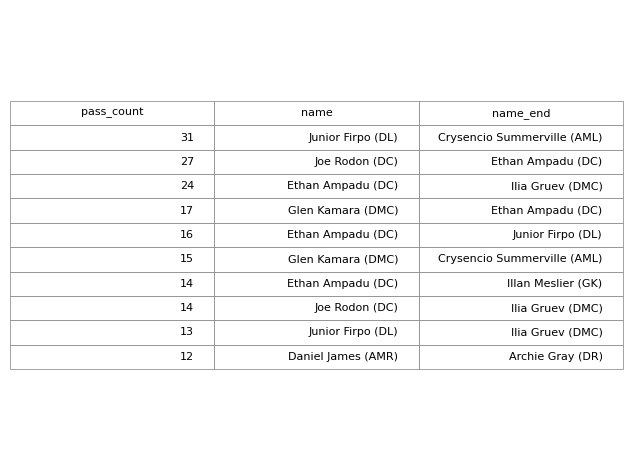

In [35]:
df1 = home_passes_between_df[['pass_count', 'name', 'position', 'name_end', 'position_end']].sort_values('pass_count', ascending=False).head(10)

df1['name'] = df1['name'].astype(str) + " (" + df1['position'] + ")"
df1['name_end'] = df1['name_end'].astype(str) + " (" + df1['position_end'] + ")"

df1 = df1.drop(['position', 'position_end'], axis=1)

#define figure and axes
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=df1.values, colLabels=df1.columns, loc='center')

# Customize the appearance of the table
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)  # Adjust the table size

# Add cell borders
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    cell.set_edgecolor('gray')

#display table
fig.tight_layout()
plt.savefig('outputs/output1.png', bbox_inches='tight')
plt.show()

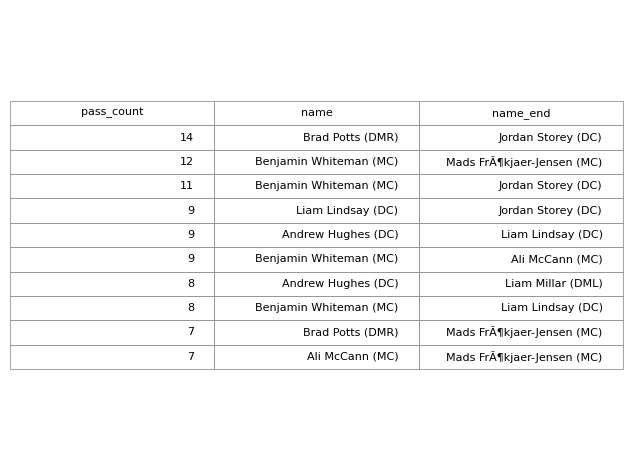

In [36]:
df2 = away_passes_between_df[['pass_count', 'name', 'position', 'name_end', 'position_end']].sort_values('pass_count', ascending=False).head(10)

df2['name'] = df2['name'].astype(str) + " (" + df2['position'] + ")"
df2['name_end'] = df2['name_end'].astype(str) + " (" + df2['position_end'] + ")"

df2 = df2.drop(['position', 'position_end'], axis=1)

#define figure and axes
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

table = ax.table(cellText=df2.values, colLabels=df2.columns, loc='center')

# Customize the appearance of the table
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.2)  # Adjust the table size

# Add cell borders
for key, cell in table.get_celld().items():
    cell.set_linewidth(0.5)
    cell.set_edgecolor('gray')

#display table
fig.tight_layout()
plt.savefig('outputs/output2.png', bbox_inches='tight')
plt.show()